## **Data Preparation and Pre-processing with Augmentation**

In this notebook, we will:
- Load and combine the matches and pubmed datasets.
- Perform image pre-processing and augmentation.
- Visualize some examples of the augmented images.
- Save the pre-processed images for embedding generation.

---

## **Table of Contents**
---
1. Import Libraries
2. Define Directories and Load Data
3. Combine Datasets
4. Define Image Pre-processing and Augmentation Functions
5. Apply Augmentation and Save Pre-processed Images
6. Visualize Augmented Images
7. Save Augmented Image Mapping
8. Clear Memory
9. Conclusion

---
### **Step 1: Import Libraries**

We begin by importing the necessary libraries.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import random
import gc

---
### **Step 2: Define Directories and Load Data**

We set up the directories for the datasets and load the image file names.

In [2]:
# Define directories
matches_dir = './matches/'
pubmed_dir = './pubmed_set/images'

# Combined dataset directory
combined_dir = './combined_dataset/'
os.makedirs(combined_dir, exist_ok=True)

# Get list of image files
matches_files = [f for f in os.listdir(matches_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
pubmed_files = [f for f in os.listdir(pubmed_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"Number of images in matches dataset: {len(matches_files)}")
print(f"Number of images in pubmed dataset: {len(pubmed_files)}")

# Path to the captions file in the pubmed dataset
pubmed_captions = './pubmed_set/'
captions_file = os.path.join(pubmed_captions, 'captions.json')

# Load captions
import json
with open(captions_file, 'r') as f:
    captions_data = json.load(f)

Number of images in matches dataset: 51
Number of images in pubmed dataset: 3309


---
### **Step 3: Combine Datasets**

We combine the two datasets into one directory.

In [3]:
# Copy images from matches dataset
for file_name in matches_files:
    src = os.path.join(matches_dir, file_name)
    dst = os.path.join(combined_dir, file_name)
    if not os.path.exists(dst):
        shutil.copy2(src, dst)

# Copy images from pubmed dataset
for file_name in pubmed_files:
    src = os.path.join(pubmed_dir, file_name)
    dst = os.path.join(combined_dir, file_name)
    if not os.path.exists(dst):
        shutil.copy2(src, dst)

# Get combined list of image files
combined_files = [f for f in os.listdir(combined_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Total number of images in combined dataset: {len(combined_files)}")

Total number of images in combined dataset: 3360


---
### **Step 4: Define Helper Functions**

We define functions to perform image pre-processing and augmentation.

In [4]:
# Set random seed for reproducibility
random.seed(42)

# Define image size expected by models (e.g., 224x224)
image_size = 224

# Define pre-processing transformation (Resize to standard dimensions)
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Function to perform cropping
def crop_image(img):
    width, height = img.size
    crops = []
    
    # Calculate coordinates for quadrants
    left_top = img.crop((0, 0, width // 2, height // 2))
    right_top = img.crop((width // 2, 0, width, height // 2))
    left_bottom = img.crop((0, height // 2, width // 2, height))
    right_bottom = img.crop((width // 2, height // 2, width, height))
    
    # Middle crop
    middle_crop_size = min(width, height) // 2
    middle_crop = img.crop((
        (width - middle_crop_size) // 2,
        (height - middle_crop_size) // 2,
        (width + middle_crop_size) // 2,
        (height + middle_crop_size) // 2
    ))
    
    crops.extend([left_top, right_top, left_bottom, right_bottom, middle_crop])
    return crops

# Function to perform rotation without black corners
def rotate_image(img):
    rotations = []
    for angle in [90, 180, 270]:
        rotated_img = img.rotate(angle, expand=True)
        # Crop the rotated image to remove any black borders
        rotated_img = rotated_img.crop(rotated_img.getbbox())
        # Resize to standard dimensions
        rotated_img = rotated_img.resize((image_size, image_size))
        rotations.append(rotated_img)
    return rotations

# Function to perform augmentation and pre-processing
def augment_and_preprocess(image_path):
    img = Image.open(image_path).convert('RGB')
    augmented_images = []
    
    # Normalization (Resize)
    img_resized = img.resize((image_size, image_size))
    augmented_images.append(img_resized)
    
    # Cropping
    crops = crop_image(img)
    for crop in crops:
        crop_resized = crop.resize((image_size, image_size))
        augmented_images.append(crop_resized)
    
    # Flipping (Rotations)
    rotations = rotate_image(img)
    augmented_images.extend(rotations)
    
    return augmented_images

---
### **Step 5: Apply Augmentation and Save Pre-processed Images**

We apply the augmentation transformations to each image and save the augmented images.

In [5]:
# Directory to save augmented images
augmented_dir = './augmented_dataset/'
os.makedirs(augmented_dir, exist_ok=True)

# Prepare a DataFrame to map augmented images to original images
augmented_image_mapping = []

# Get list of all images in the combined dataset
image_files = os.listdir(combined_dir)

# Apply augmentation and save images
for image_file in tqdm(image_files, desc='Processing Images'):
    image_path = os.path.join(combined_dir, image_file)
    augmented_images = augment_and_preprocess(image_path)
    
    for idx, aug_img in enumerate(augmented_images):
        # Generate a unique filename for the augmented image
        aug_image_filename = f'{os.path.splitext(image_file)[0]}_aug_{idx}.jpg'
        aug_image_path = os.path.join(augmented_dir, aug_image_filename)
        # Save the augmented image
        aug_img.save(aug_image_path)
        # Record the mapping
        augmented_image_mapping.append({
            'original_image': image_file,
            'augmented_image': aug_image_filename
        })

    # Clear memory
    del augmented_images
    gc.collect()


Processing Images: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3360/3360 [03:31<00:00, 15.85it/s]


---
### **Step 6: Visualize Augmented Images**

Visualize Augmented Images

Original Image: f4c799a2-a2b1-469d-adfb-8b7d8c4d4634.jpg
Original Image:


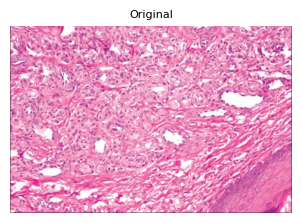

Augmented Images:


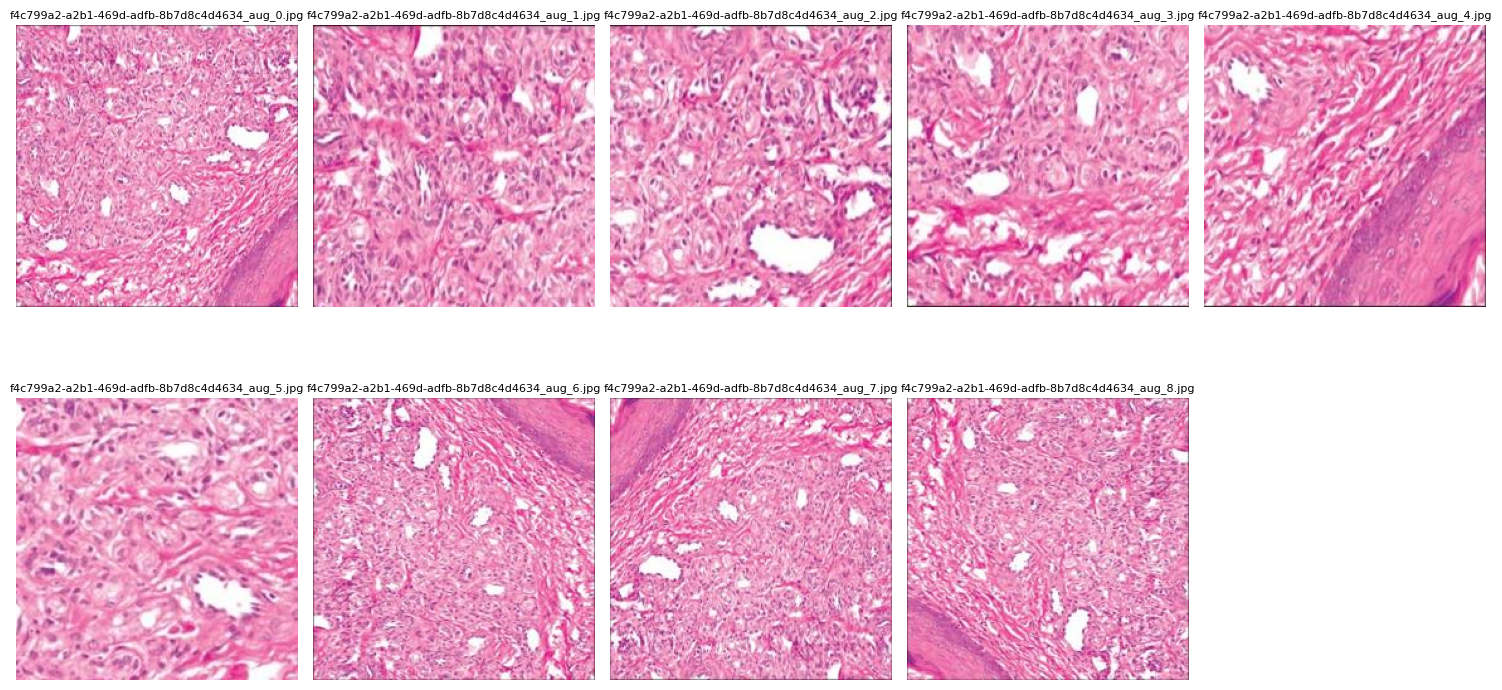

In [6]:
# Function to display images
def display_images(image_paths, titles=None, cols=5, figsize=(15, 8)):
    rows = len(image_paths) // cols + int(len(image_paths) % cols != 0)
    plt.figure(figsize=figsize)
    for idx, img_path in enumerate(image_paths):
        plt.subplot(rows, cols, idx+1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        if titles:
            plt.title(titles[idx], fontsize=8)
    plt.tight_layout()
    plt.show()

# Randomly select an original image
sample_original_image = random.choice(image_files)
print(f'Original Image: {sample_original_image}')

# Get all augmented versions of this image
augmented_versions = [entry['augmented_image'] for entry in augmented_image_mapping if entry['original_image'] == sample_original_image]
augmented_image_paths = [os.path.join(augmented_dir, img_file) for img_file in augmented_versions]

# Display the original image and its augmentations
original_image_path = os.path.join(combined_dir, sample_original_image)
print("Original Image:")
display_images([original_image_path], titles=['Original'])

print("Augmented Images:")
display_images(augmented_image_paths, titles=augmented_versions)

---
### **Step 7: Save Augmented Image Mapping**

We save the mapping between original images and their augmented counterparts.

In [8]:
# Convert mapping to DataFrame and save
augmented_df = pd.DataFrame(augmented_image_mapping)
augmented_df.to_csv('augmented_image_mapping.csv', index=False)
print("Augmented image mapping saved.")

Augmented image mapping saved.


---
### **Step 8: Clear Memory**

We clear variables and free up memory.

In [13]:
# Clear variables and free memory
del augmented_image_mapping, augmented_df
gc.collect()

24716

## **Conclusion**

We have successfully:
- Combined the matches and pubmed datasets.
- Applied image pre-processing and augmentation techniques.
- Visualized examples of augmented images.
- Saved the pre-processed images for embedding generation.